In [ ]:
!pip install osmnx
!pip install networkx
!pip install geopy

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Route calculation

## Calculate shortest path between 2 points using `NetworkX` package

In [2]:
import pickle
import osmnx as ox
import networkx as nx
ox.config(log_console=True, use_cache=True)
from geopy.geocoders import Nominatim

In [3]:
# location where you want to find your route
place = 'Berlin, Germany'
# find shortest route based on the mode of travel
mode = 'walk'       # 'drive', 'bike', 'walk'

# create graph from OSM within the boundaries of some geocodable place(s) and save as pickle file
# graph = ox.graph_from_place(place, network_type = mode)
# with open('/content/drive/MyDrive/Colab_Notebooks/02_HWR/00_data/graph_berlin.obj', 'wb') as fp:
#    pickle.dump(graph, fp)

#load stored graph pickle file
with open('/content/drive/MyDrive/Colab_Notebooks/02_HWR/00_data/graph_berlin.obj', 'rb') as fp:
  graph_bln = pickle.load(fp)

In [13]:
# stores the start and end points as geopy.point.Point objects
locator = Nominatim(user_agent = "myapp")

# define the start and end locations as text (user input)
start_location = "Arndtstraße 28, 10965 Berlin"
end_location = "Badensche Straße 52, 10825 Berlin"

# stores the start and end points as geopy.point.Point objects
start_latlng = locator.geocode(start_location).point
end_latlng = locator.geocode(end_location).point

# find the nearest node to the start location
# orig_node = ox.get_nearest_node(graph_bln, start_latlng) (deprecated function)
orig_node = ox.distance.nearest_nodes(graph_bln, start_latlng[1], start_latlng[0])

# find the nearest node to the end location
#dest_node = ox.get_nearest_node(graph_bln, end_latlng) (deprecated function)
dest_node = ox.distance.nearest_nodes(graph_bln, end_latlng[1], end_latlng[0])

In [14]:
# find shortest path based on distance or time
optimizer = 'length'        # 'length','time'

#  find the shortest path
shortest_route = nx.shortest_path(graph_bln,
                                  orig_node,
                                  dest_node,
                                  weight=optimizer)

In [15]:
import folium

shortest_route_map = ox.plot_route_folium(graph_bln, shortest_route)

# Marker class only accepts coordinates in tuple form
start_latlng = (start_latlng[0],start_latlng[1])
end_latlng   = (end_latlng[0],end_latlng[1])
start_marker = folium.Marker(
            location = start_latlng,
            popup = start_location,
            icon = folium.Icon(color='green'))
end_marker = folium.Marker(
            location = end_latlng,
            popup = end_location,
            icon = folium.Icon(color='red'))
# add the circle marker to the map
start_marker.add_to(shortest_route_map)
end_marker.add_to(shortest_route_map)
shortest_route_map

## Plotting: Add second destination to map (from A to B to C)

In [62]:
# stores the start and end points as geopy.point.Point objects
locator = Nominatim(user_agent = "myapp")

# define the start and end locations as text (user input)
start_location2 = end_location
end_location2 = "Bayerischer Pl. 1, 10779 Berlin"

# stores the start and end points as geopy.point.Point objects
start_latlng2 = locator.geocode(start_location2).point
end_latlng2 = locator.geocode(end_location2).point

# find the nearest node to the start location
# orig_node = ox.get_nearest_node(graph_bln, start_latlng) (deprecated function)
orig_node2 = ox.distance.nearest_nodes(graph_bln, start_latlng2[1], start_latlng2[0])

# find the nearest node to the end location
#dest_node = ox.get_nearest_node(graph_bln, end_latlng) (deprecated function)
dest_node2 = ox.distance.nearest_nodes(graph_bln, end_latlng2[1], end_latlng2[0])

In [63]:
# find shortest path based on distance or time
optimizer = 'length'        # 'length','time'

#  find the shortest path
shortest_route2 = nx.shortest_path(graph_bln,
                                  orig_node2,
                                  dest_node2,
                                  weight=optimizer)

In [76]:
# combine poth paths (important do not include first element of 2nd list since these are the same coordinates -> no route between a point and itself)
combined_route= shortest_route+shortest_route2[1:]

In [78]:
#plot combined route
shortest_route_map_cmb = ox.plot_route_folium(graph_bln, combined_route)

# Marker class only accepts coordinates in tuple form
start_latlng = (start_latlng[0],start_latlng[1])
end_latlng   = (end_latlng[0],end_latlng[1])
end_latlng2   = (end_latlng2[0],end_latlng2[1])

start_marker = folium.Marker(
            location = start_latlng,
            popup = start_location,
            icon = folium.Icon(color='green'))
end_marker = folium.Marker(
            location = end_latlng,
            popup = end_location,
            icon = folium.Icon(color='green'))
end_marker2 = folium.Marker(
            location = end_latlng2,
            popup = end_location,
            icon = folium.Icon(color='red'))
# add the circle marker to the map
start_marker.add_to(shortest_route_map_cmb)
end_marker.add_to(shortest_route_map_cmb)
end_marker2.add_to(shortest_route_map_cmb)
shortest_route_map_cmb

## [`Traveling Salesman problem`](https://en.wikipedia.org/wiki/Travelling_salesman_problem#Heuristic_and_approximation_algorithms)
- These algorithms may be the solution to our problem to calculate the best route between different points
- There are some functions already implemented in [NetworkX](https://networkx.org/documentation/stable/reference/algorithms/approximation.html?highlight=approximation#module-networkx.algorithms.approximation.traveling_salesman)

In [19]:
# Greedy salesman approach
from networkx.algorithms import approximation as approx

In [34]:
graph_kronau = ox.graph_from_place("kronau-germany", network_type = mode)
with open('/content/drive/MyDrive/Colab_Notebooks/02_HWR/00_data/graph_kronau.obj', 'wb') as fp:
    pickle.dump(graph_kronau, fp)

In [27]:
# Get all parks around given address within 1000m
address = "Benzstraße 16, 76709 Kronau"
tags = {"leisure":"park"}
kronau = ox.geometries.geometries_from_address(address, tags, dist=1000)

In [88]:
# Get first node from each park 
park_nodes = kronau.nodes.apply(lambda x: x[0]).to_list()

In [92]:
nodes_kronau = list(graph_kronau.nodes())

In [96]:
#only keep park nodes whcih are within graph node
park_nodes_cln = [node for node in park_nodes if node in nodes_kronau]

In [98]:
#List of nodes in graph_kronau along a path with an approximation of the minimal path through nodes.
TSM_path_kronau = approx.traveling_salesman_problem(graph_kronau, nodes=park_nodes_cln)

In [99]:
#Plot route whch passes by all parks
ox.plot_route_folium(graph_kronau, TSM_path_kronau)

### Backup: Converting geopandas and graphs

In [38]:
# impute edge (driving) speeds and calculate edge traversal times
G = ox.add_edge_speeds(graph_kronau)
G = ox.add_edge_travel_times(G)

# you can convert MultiDiGraph to/from geopandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
#G = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

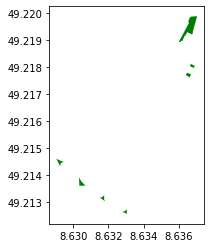

In [51]:
kronau.plot(marker='*', color='green', markersize=5);
kronau_parks = kronau.to_crs(gdf_nodes.crs)

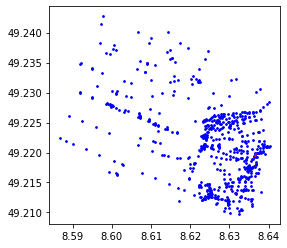

In [106]:
base = gdf_nodes.plot(color='blue', markersize=3)

kronau_parks.plot(ax=base, color='red', markersize=15);